In [1]:
!pip install networkx gensim torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import networkx as nx
import pandas as pd
import torch

In [3]:
edges = pd.read_csv('cora.cites', sep='\t', header=None, names=['source', 'target'])
nodes = pd.read_csv('cora.content', sep='\t', header=None)

In [4]:
all_nodes = pd.concat([edges['source'], edges['target']]).unique()

node_mapping = {node_id: idx for idx, node_id in enumerate(all_nodes)}

edges['source'] = edges['source'].map(node_mapping)
edges['target'] = edges['target'].map(node_mapping)

In [5]:
G = nx.from_pandas_edgelist(edges, 'source', 'target')

In [6]:
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

features = torch.tensor(nodes.iloc[:, 1:-1].values, dtype=torch.float)
labels = LabelEncoder().fit_transform(nodes.iloc[:, -1])
labels = torch.tensor(labels, dtype=torch.long)

edge_index = torch.tensor(list(map(list, zip(*G.edges))), dtype=torch.long)

data = Data(x=features, edge_index=edge_index, y=labels)

In [13]:
from torch_geometric.nn import GATConv
import numpy as np

class GATNet(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [17]:
import torch.nn.functional as F

model = GATNet(num_features=data.num_features, num_classes=len(np.unique(data.y.numpy())))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_mask = torch.rand(features.shape[0]) < 0.1
data.train_mask = train_mask

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

losses = []

for epoch in range(200):
    loss = train()
    print("Epoch: " + str(epoch) + " Loss: " + str(loss))
    losses.append(loss)

Epoch: 0 Loss: 2.0547633171081543
Epoch: 1 Loss: 2.0252556800842285
Epoch: 2 Loss: 2.0682291984558105
Epoch: 3 Loss: 2.0512354373931885
Epoch: 4 Loss: 2.059520959854126
Epoch: 5 Loss: 2.0328803062438965
Epoch: 6 Loss: 2.065687417984009
Epoch: 7 Loss: 2.004934072494507
Epoch: 8 Loss: 1.9988796710968018
Epoch: 9 Loss: 1.999363660812378
Epoch: 10 Loss: 1.933566689491272
Epoch: 11 Loss: 1.9588583707809448
Epoch: 12 Loss: 2.032224178314209
Epoch: 13 Loss: 1.9103785753250122
Epoch: 14 Loss: 1.995359182357788
Epoch: 15 Loss: 1.9475525617599487
Epoch: 16 Loss: 1.9443995952606201
Epoch: 17 Loss: 1.9169107675552368
Epoch: 18 Loss: 1.9197396039962769
Epoch: 19 Loss: 1.916510820388794
Epoch: 20 Loss: 1.965414047241211
Epoch: 21 Loss: 1.9814801216125488
Epoch: 22 Loss: 1.8964793682098389
Epoch: 23 Loss: 1.910085678100586
Epoch: 24 Loss: 1.937630295753479
Epoch: 25 Loss: 1.8989746570587158
Epoch: 26 Loss: 1.9260764122009277
Epoch: 27 Loss: 1.8651412725448608
Epoch: 28 Loss: 1.84893000125885
Epoch: 2

In [ ]:
print(torch.tensor(nx.to_numpy_array(G), dtype=torch.float))

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])


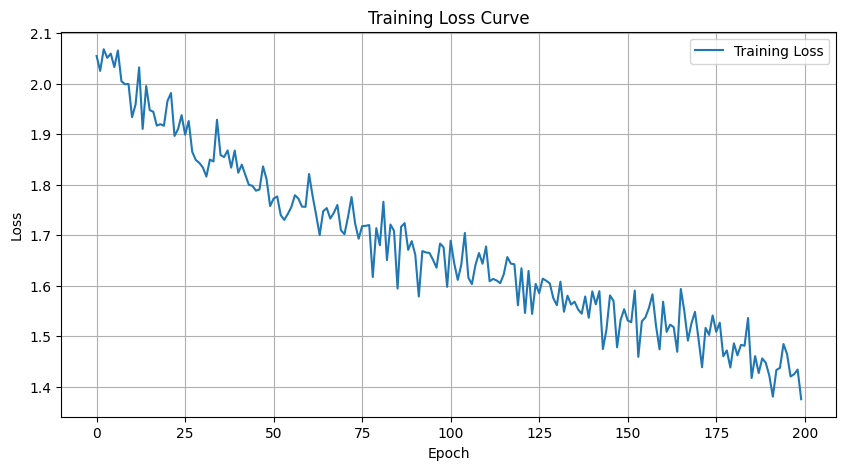

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
!pip install python-louvain

In [20]:
out = model(data.x, data.edge_index)
predictions = out.max(dim=1)[1]

In [31]:
import networkx as nx
from community import community_louvain

G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
G.add_edges_from(data.edge_index.t().tolist())

communities = {node: int(community) for node, community in enumerate(predictions.tolist())}

partition = community_louvain.best_partition(G, partition=communities)
modularity_score = community_louvain.modularity(partition, G)
print(f"Modularity Score: {modularity_score}")

Modularity Score: 0.6338394654697852


In [32]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [33]:
true_labels = data.y.numpy()

predicted_labels = predictions.numpy()

In [34]:
nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Normalized Mutual Information (NMI): 0.0097
Adjusted Rand Index (ARI): 0.0043
